In [1]:
import os
import cv2
import json
import torch
import wandb
import optuna
import shutil
import logging
import numpy as np
import torchvision
import torch.optim as optim
import torchvision.ops as ops
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
from tqdm import tqdm
from PIL import Image
from collections import Counter
from torchsummary import summary
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score
from typing import Dict, Any, Optional
from torchvision import transforms , models
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

src = "/content/drive/MyDrive/kitti2012"
dst = "/content"
os.makedirs(dst, exist_ok=True)

!cp -r "$src" "$dst"

wandb.login()

Mounted at /content/drive


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mehmeteminuludag (mehmeteminuludag-kirikkale-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [2]:
def kitti_collate_fn(batch):
    images = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    images = torch.stack(images, dim=0)  # [B, C, H, W]
    return images, labels

def analyze_dataset(train_dataset, device):

    """
    Veri seti analizi ve görselleştirme fonksiyonu
    """

    # === 0. Veri Setinden Özellikleri Çıkarma ===
    print(f"Veri seti boyutu: {len(train_dataset)} örnek")

    cls_labels = []
    depth_maps = []
    bboxes = []

    for i in range(len(train_dataset)):
        for j in range(len(train_dataset[i][1])):
            cls_labels.append(train_dataset[i][1][j][0])
            depth_maps.append(train_dataset[i][1][j][5])
            bboxes.append(train_dataset[i][1][j][1:4])

    print(f"Toplam obje sayısı: {len(cls_labels)}")
    print(f"Toplam bbox sayısı: {len(bboxes)}")
    print(f"Toplam depth değeri: {len(depth_maps)}")

    # === 1. Sınıf Dağılımı Analizi ===
    cls_distribution = Counter(cls_labels)
    sorted_cls_distribution = sorted(cls_distribution.items(), key=lambda x: x[0])

    # Class weights hesaplama
    class_weights = torch.tensor([i[1] for i in sorted_cls_distribution],
                                dtype=torch.float32).to(device)

    # === 2. BBox Analizi (Yeni Eklenen) ===
    # BBox boyutları analizi
    bbox_widths = [bbox[2] - bbox[0] for bbox in bboxes]  # x2 - x1
    bbox_heights = [bbox[3] - bbox[1] for bbox in bboxes]  # y2 - y1
    bbox_areas = [w * h for w, h in zip(bbox_widths, bbox_heights)]
    bbox_aspect_ratios = [w / h if h > 0 else 0 for w, h in zip(bbox_widths, bbox_heights)]

    # === 3. Görsel Başına Obje Sayısı Analizi ===
    objects_per_image = []
    for i in range(len(train_dataset)):
        objects_per_image.append(len(train_dataset[i][1]))

    # === 4. Depth Analizi ===
    # NaN olmayan depth değerlerini filtrele
    valid_depths = [d for d in depth_maps if not np.isnan(d)]
    invalid_depths = len(depth_maps) - len(valid_depths)

    # Depth istatistikleri
    depth_stats = {
        'Min': np.min(valid_depths) if valid_depths else 0,
        'Max': np.max(valid_depths) if valid_depths else 0,
        'Mean': np.mean(valid_depths) if valid_depths else 0,
        'Median': np.median(valid_depths) if valid_depths else 0,
        'Std': np.std(valid_depths) if valid_depths else 0
    }

    # === 5. Görselleştirme ===
    fig = plt.figure(figsize=(18, 12))

    # Sınıf dağılımı pasta grafiği
    plt.subplot(3, 4, 1)
    labels, values = zip(*sorted_cls_distribution)
    plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title('Sınıf Dağılımı', fontsize=12, fontweight='bold')
    plt.axis('equal')

    # Sınıf dağılımı bar grafiği
    plt.subplot(3, 4, 2)
    plt.bar(labels, values, alpha=0.7, edgecolor='black')
    plt.title('Sınıf Dağılımı (Bar Chart)', fontsize=12, fontweight='bold')
    plt.xlabel('Sınıf')
    plt.ylabel('Örnek Sayısı')
    plt.xticks(rotation=45)

    # Görsel başına obje sayısı histogramı
    plt.subplot(3, 4, 3)
    plt.hist(objects_per_image, bins=range(1, max(objects_per_image)+2),
             alpha=0.7, edgecolor='black', color='skyblue')
    plt.title('Görsel Başına Obje Sayısı', fontsize=12, fontweight='bold')
    plt.xlabel('Obje Sayısı')
    plt.ylabel('Görsel Sayısı')
    plt.grid(True, alpha=0.3)

    # BBox genişlik histogramı
    plt.subplot(3, 4, 4)
    plt.hist(bbox_widths, bins=50, alpha=0.7, edgecolor='black', color='orange')
    plt.title('BBox Genişlik Dağılımı', fontsize=12, fontweight='bold')
    plt.xlabel('Genişlik')
    plt.ylabel('Frekans')
    plt.grid(True, alpha=0.3)

    # BBox yükseklik histogramı
    plt.subplot(3, 4, 5)
    plt.hist(bbox_heights, bins=50, alpha=0.7, edgecolor='black', color='red')
    plt.title('BBox Yükseklik Dağılımı', fontsize=12, fontweight='bold')
    plt.xlabel('Yükseklik')
    plt.ylabel('Frekans')
    plt.grid(True, alpha=0.3)

    # BBox alan histogramı
    plt.subplot(3, 4, 6)
    plt.hist(bbox_areas, bins=50, alpha=0.7, edgecolor='black', color='purple')
    plt.title('BBox Alan Dağılımı', fontsize=12, fontweight='bold')
    plt.xlabel('Alan')
    plt.ylabel('Frekans')
    plt.grid(True, alpha=0.3)

    # BBox aspect ratio histogramı
    plt.subplot(3, 4, 7)
    plt.hist(bbox_aspect_ratios, bins=50, alpha=0.7, edgecolor='black', color='brown')
    plt.title('BBox En/Boy Oranı', fontsize=12, fontweight='bold')
    plt.xlabel('En/Boy Oranı')
    plt.ylabel('Frekans')
    plt.grid(True, alpha=0.3)

    # Depth değerleri histogramı
    plt.subplot(3, 4, 8)
    if valid_depths:
        plt.hist(valid_depths, bins=50, alpha=0.7, edgecolor='black', color='lightgreen')
    plt.title('Depth Değerleri Dağılımı', fontsize=12, fontweight='bold')
    plt.xlabel('Normalize Edilmiş Depth')
    plt.ylabel('Frekans')
    plt.grid(True, alpha=0.3)

    # Depth box plot
    plt.subplot(3, 4, 9)
    if valid_depths:
        plt.boxplot(valid_depths, vert=True)
    plt.title('Depth Box Plot', fontsize=12, fontweight='bold')
    plt.ylabel('Normalize Edilmiş Depth')
    plt.grid(True, alpha=0.3)

    # Obje sayısı box plot
    plt.subplot(3, 4, 10)
    plt.boxplot(objects_per_image, vert=True)
    plt.title('Obje Sayısı Box Plot', fontsize=12, fontweight='bold')
    plt.ylabel('Obje Sayısı')
    plt.grid(True, alpha=0.3)

    # BBox alan box plot
    plt.subplot(3, 4, 11)
    plt.boxplot(bbox_areas, vert=True)
    plt.title('BBox Alan Box Plot', fontsize=12, fontweight='bold')
    plt.ylabel('Alan')
    plt.grid(True, alpha=0.3)

    # BBox aspect ratio box plot
    plt.subplot(3, 4, 12)
    plt.boxplot(bbox_aspect_ratios, vert=True)
    plt.title('En/Boy Oranı Box Plot', fontsize=12, fontweight='bold')
    plt.ylabel('En/Boy Oranı')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # === 6. İstatistik Raporları ===
    print("=" * 80)
    print("DATASET ANALİZ RAPORU")
    print("=" * 80)

    # Genel bilgiler
    print(f"\n📋 GENEL BİLGİLER:")
    print(f"Toplam görsel sayısı:    {len(train_dataset):6d}")
    print(f"Toplam obje sayısı:      {len(cls_labels):6d}")
    print(f"Toplam bbox sayısı:      {len(bboxes):6d}")

    # Sınıf dağılımı raporu
    print(f"\n SINIF DAĞILIMI:")
    print(f"Toplam sınıf sayısı: {len(cls_distribution)}")
    for label, count in sorted_cls_distribution:
        percentage = (count / sum(cls_distribution.values())) * 100
        print(f"  Sınıf {label}: {count:4d} örnek ({percentage:5.1f}%)")

    # BBox analiz raporu
    print(f"\n BBOX ANALİZ RAPORU:")
    print(f"Ortalama genişlik:       {np.mean(bbox_widths):8.2f}")
    print(f"Ortalama yükseklik:      {np.mean(bbox_heights):8.2f}")
    print(f"Ortalama alan:           {np.mean(bbox_areas):8.2f}")
    print(f"Ortalama en/boy oranı:   {np.mean(bbox_aspect_ratios):8.2f}")
    print(f"Min genişlik:            {np.min(bbox_widths):8.2f}")
    print(f"Max genişlik:            {np.max(bbox_widths):8.2f}")
    print(f"Min yükseklik:           {np.min(bbox_heights):8.2f}")
    print(f"Max yükseklik:           {np.max(bbox_heights):8.2f}")
    print(f"Min alan:                {np.min(bbox_areas):8.2f}")
    print(f"Max alan:                {np.max(bbox_areas):8.2f}")

    # Obje sayısı raporu
    print(f"\n OBJE SAYISI İSTATİSTİKLERİ:")
    print(f"Ortalama obje sayısı: {np.mean(objects_per_image):6.2f}")
    print(f"Medyan obje sayısı:   {np.median(objects_per_image):6.2f}")
    print(f"Maksimum obje sayısı: {max(objects_per_image):6d}")
    print(f"Minimum obje sayısı:  {min(objects_per_image):6d}")
    print(f"Standart sapma:       {np.std(objects_per_image):6.2f}")

    # Depth raporu
    print(f"\n DEPTH ANALİZ RAPORU:")
    print(f"Toplam depth değeri:     {len(depth_maps):6d}")
    print(f"Geçerli depth değeri:    {len(valid_depths):6d}")
    print(f"Geçersiz depth (NaN):    {invalid_depths:6d}")
    print(f"Depth geçerlilik oranı:  {len(valid_depths)/len(depth_maps)*100:6.1f}%")

    if valid_depths:
        print(f"\n DEPTH İSTATİSTİKLERİ:")
        for key, value in depth_stats.items():
            print(f"{key:>8}: {value:8.4f}")

    print("=" * 80)

    return {
        'class_weights': class_weights,
        'cls_distribution': sorted_cls_distribution,
        'bbox_stats': {
            'mean_width': np.mean(bbox_widths),
            'mean_height': np.mean(bbox_heights),
            'mean_area': np.mean(bbox_areas),
            'mean_aspect_ratio': np.mean(bbox_aspect_ratios),
            'width_std': np.std(bbox_widths),
            'height_std': np.std(bbox_heights),
            'area_std': np.std(bbox_areas)
        },
        'objects_per_image_stats': {
            'mean': np.mean(objects_per_image),
            'median': np.median(objects_per_image),
            'max': max(objects_per_image),
            'min': min(objects_per_image),
            'std': np.std(objects_per_image)
        },
        'depth_stats': depth_stats,
        'depth_validity_ratio': len(valid_depths)/len(depth_maps)*100 if depth_maps else 0,
        'total_images': len(train_dataset),
        'total_objects': len(cls_labels)
    }

def calculate_metrics(outputs, targets, threshold=0.1, iou_threshold=0.5):
    """Overflow korumalı metrik hesaplama"""
    metrics = {
        'f1_score': 0.0,
        'accuracy': 0.0,
        'rmse': 0.0,
        'mAP': 0.0
    }

    try:
        # Sınıflandırma metrikleri
        if 'classification' in outputs and 'classification' in targets:
            cls_output = torch.sigmoid(outputs['classification'].mean(dim=[2, 3])).detach()

            # NaN/Inf kontrolü
            if torch.isnan(cls_output).any() or torch.isinf(cls_output).any():
                print("Warning: NaN/Inf detected in classification output")
                cls_output = torch.clamp(cls_output, 0, 1)  # Güvenli aralığa sıkıştır

            cls_pred = (cls_output > threshold).cpu().numpy().astype(int)
            batch_size = targets['classification'].shape[0]
            num_classes = outputs['classification'].shape[1]
            cls_targets = np.zeros((batch_size, num_classes), dtype=int)

            for b in range(batch_size):
                valid_objects = targets['classification'][b][targets['classification'][b] >= 0]
                for cls in valid_objects.detach().cpu().numpy():
                    if 0 <= int(cls) < num_classes:
                        cls_targets[b, int(cls)] = 1

            metrics['f1_score'] = f1_score(cls_targets.flatten(), cls_pred.flatten(), average='macro', zero_division=0)
            metrics['accuracy'] = accuracy_score(cls_targets.flatten(), cls_pred.flatten())

        # GÜVENL İ RMSE hesaplaması
        if 'regression' in outputs and 'regression' in targets:
            reg_output = outputs['regression'].mean(dim=[2, 3]).detach().cpu().numpy()

            # NaN/Inf kontrolü
            if np.isnan(reg_output).any() or np.isinf(reg_output).any():
                print("Warning: NaN/Inf detected in regression output")
                reg_output = np.nan_to_num(reg_output, nan=0.0, posinf=1.0, neginf=-1.0)

            # Bounding box koordinatlarını güvenli aralığa sıkıştır
            reg_output = np.clip(reg_output, -10.0, 10.0)  # KRITIK: Koordinatları sınırla

            batch_size = targets['regression'].shape[0]
            all_pred_boxes = []
            all_target_boxes = []

            for b in range(batch_size):
                valid_objects = targets['classification'][b][targets['classification'][b] >= 0]
                num_valid = len(valid_objects)

                if num_valid > 0:
                    pred_box = reg_output[b]
                    gt_boxes = targets['regression'][b][:num_valid].detach().cpu().numpy()

                    # GT boxes'ları da sınırla
                    gt_boxes = np.clip(gt_boxes, -10.0, 10.0)

                    for i in range(num_valid):
                        all_pred_boxes.append(pred_box)
                        all_target_boxes.append(gt_boxes[i])

            if all_pred_boxes and all_target_boxes:
                all_pred_boxes = np.array(all_pred_boxes)
                all_target_boxes = np.array(all_target_boxes)

                # Güvenli MSE hesaplama
                diff = all_pred_boxes - all_target_boxes
                diff = np.clip(diff, -5.0, 5.0)  # Farkları sınırla

                mse_per_sample = np.mean(diff ** 2, axis=1)

                # MSE değerlerini kontrol et
                if np.isnan(mse_per_sample).any() or np.isinf(mse_per_sample).any():
                    print("Warning: NaN/Inf in MSE calculation")
                    mse_per_sample = np.nan_to_num(mse_per_sample, nan=1.0, posinf=1.0, neginf=1.0)

                # Outlier filtreleme
                if len(mse_per_sample) > 1:
                    percentile_95 = np.percentile(mse_per_sample, 95)
                    valid_mask = mse_per_sample <= percentile_95

                    if valid_mask.any():
                        filtered_mse = mse_per_sample[valid_mask]
                        metrics['rmse'] = min(np.sqrt(np.mean(filtered_mse)), 1.0)  # RMSE'yi sınırla
                    else:
                        metrics['rmse'] = min(np.sqrt(np.mean(mse_per_sample)), 1.0)
                else:
                    metrics['rmse'] = min(np.sqrt(mse_per_sample[0]) if len(mse_per_sample) > 0 else 1.0, 1.0)
            else:
                metrics['rmse'] = 0.0

        # Güvenli mAP hesaplaması (basitleştirilmiş)
        if 'classification' in outputs and 'regression' in outputs and 'classification' in targets and 'regression' in targets:
            try:
                cls_output = torch.sigmoid(outputs['classification'].mean(dim=[2, 3])).detach().cpu().numpy()
                reg_output = outputs['regression'].mean(dim=[2, 3]).detach().cpu().numpy()

                # Output kontrolü
                if np.isnan(cls_output).any() or np.isinf(cls_output).any():
                    cls_output = np.clip(cls_output, 0, 1)
                if np.isnan(reg_output).any() or np.isinf(reg_output).any():
                    reg_output = np.clip(reg_output, -5, 5)

                batch_size = targets['classification'].shape[0]
                num_classes = cls_output.shape[1]

                total_predictions = 0
                total_correct = 0

                for b in range(batch_size):
                    cls_scores = cls_output[b]
                    valid_objects = targets['classification'][b][targets['classification'][b] >= 0]

                    if len(valid_objects) > 0:
                        # Basit doğruluk hesabı
                        for cls_idx in range(num_classes):
                            if cls_scores[cls_idx] > threshold:
                                total_predictions += 1
                                if cls_idx in valid_objects.detach().cpu().numpy():
                                    total_correct += 1

                # Basit precision as mAP approximation
                if total_predictions > 0:
                    metrics['mAP'] = min(total_correct / total_predictions, 1.0)
                else:
                    metrics['mAP'] = 0.0

            except Exception as e:
                print(f"mAP hesaplama hatası: {e}")
                metrics['mAP'] = 0.0

    except Exception as e:
        print(f"Metrik hesaplama genel hatası: {e}")
        return metrics

    return metrics
def compute_iou(box1, box2):
    """
    Box format: [x, y, width, height] (center coordinates)
    """
    # Center format'tan corner format'a dönüştür
    x1_min = box1[0] - box1[2] / 2
    y1_min = box1[1] - box1[3] / 2
    x1_max = box1[0] + box1[2] / 2
    y1_max = box1[1] + box1[3] / 2

    x2_min = box2[0] - box2[2] / 2
    y2_min = box2[1] - box2[3] / 2
    x2_max = box2[0] + box2[2] / 2
    y2_max = box2[1] + box2[3] / 2

    # Kesişim alanını hesapla
    inter_x_min = max(x1_min, x2_min)
    inter_y_min = max(y1_min, y2_min)
    inter_x_max = min(x1_max, x2_max)
    inter_y_max = min(y1_max, y2_max)

    if inter_x_max <= inter_x_min or inter_y_max <= inter_y_min:
        return 0.0

    inter_area = (inter_x_max - inter_x_min) * (inter_y_max - inter_y_min)

    # Birleşim alanını hesapla
    area1 = box1[2] * box1[3]
    area2 = box2[2] * box2[3]
    union_area = area1 + area2 - inter_area

    if union_area <= 0:
        return 0.0

    return inter_area / union_area

def train_model(model, train_loader, val_loader, num_epochs=100,

                learning_rate=1e-4, device='cuda', save_path='model_checkpoint.pth', task_weights=None,scheduler_patience=10,class_weights=None,scheduler_factor=0.5,threshold=0.5,iou_threshold=0.5):
    val_lossess = []
    train_lossess = []
    val_accuracys = []
    train_accuracys = []
    # WandB config'e weights ekle
    config = {
        "learning_rate": learning_rate,
        "architecture": "EfficientBasedMultiTask",
        "dataset": "KITTI-2012",
        "epochs": num_epochs,
    }

    # Task weights'i config'e ekle
    if task_weights:
        config.update({
            "task_weights": task_weights,
            "classification_weight": task_weights.get("classification", 1.0),
            "regression_weight": task_weights.get("regression", 1.0),
            "detection_depth_weight": task_weights.get("detection_depth", 1.0),
            "depth_map_weight": task_weights.get("depth_map", 1.0)
        })

    wandb.init(
        entity="mehmeteminuludag-kirikkale-university",
        project="StajProjesi",
        config=config
    )

    # Setup logging


    # Move model to device
    model = model.to(device)

    # Loss function and optimizer
    criterion = MultiTaskLoss(num_tasks=4, loss_weights=task_weights,class_weights=class_weights).to(device)
    optimizer = optim.AdamW(list(model.parameters()) + list(criterion.parameters()),lr=learning_rate, weight_decay=1e-5, eps=1e-8)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                   factor=scheduler_factor, patience=scheduler_patience, verbose=True)

    # Training history için dict'ler


    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_losses = {'total': 0, 'classification': 0, 'regression': 0,
                      'detection_depth': 0, 'depth_map': 0}
        train_metrics_accum = {'f1_score': 0, 'precision': 0, 'recall': 0,
                              'accuracy': 0, 'rmse': 0,'mAP':0 , 'ClsLoss' : 0,'TotalLoss' :0,'DepthEstimationLoss':0,'DetectionLoss':0,'DepthMapLoss':0}
        train_samples = 0
        num_batches = 0

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} Train ')

        for batch_idx, (images, targets) in enumerate(pbar):
            # Move data to device
            images = images.to(device)

            # Prepare targets for KITTI format
            target_dict = {}
            batch_size = len(targets)

            # Find max number of objects in the batch for padding
            max_objects = max(len(target_list) for target_list in targets) if targets else 1

            # Initialize tensors
            cls_labels = torch.full((batch_size, max_objects), -1, dtype=torch.long)  # -1 for padding
            bbox_labels = torch.zeros((batch_size, max_objects, 4), dtype=torch.float32)
            depth_labels = torch.full((batch_size, max_objects, 1), float('nan'), dtype=torch.float32)

            # Fill the tensors
            for b, target_list in enumerate(targets):
                for obj_idx, obj_data in enumerate(target_list):
                    if obj_idx < max_objects:
                        category_num, x, y, w, h, depth_or_disp = obj_data
                        cls_labels[b, obj_idx] = int(category_num)
                        bbox_labels[b, obj_idx] = torch.tensor([x, y, w, h], dtype=torch.float32)

                        # Handle NaN values in depth/disparity
                        if not np.isnan(depth_or_disp):
                            depth_labels[b, obj_idx, 0] = depth_or_disp

            # Move to device
            target_dict['classification'] = cls_labels.to(device)
            target_dict['regression'] = bbox_labels.to(device)
            target_dict['depth'] = depth_labels.to(device)
            target_dict['depth_map'] = torch.zeros(batch_size, 1, 512, 512).to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(images, mode="train")

            # Calculate losses and metrics
            losses = criterion(outputs, target_dict)
            train_metrics = calculate_metrics(outputs, target_dict,threshold=threshold,iou_threshold=iou_threshold)

            # Backward pass
            losses['total'].backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            # Update running losses and metrics
            batch_size = images.size(0)
            train_samples += batch_size
            num_batches += 1

            for key, loss in losses.items():
                train_losses[key] += loss.item() * batch_size

            # Metrikleri accumulate et
            for key, metric in train_metrics.items():
                train_metrics_accum[key] += metric

            # Update progress bar with metrics (not losses)
            avg_metrics = {key: val / num_batches for key, val in train_metrics_accum.items()}
            pbar.set_postfix({
                'Acc': f"{avg_metrics['accuracy']:.3f}",
                'ClsLoss': f"{losses['classification']:.3f}",
                'F1': f"{avg_metrics['f1_score']:.3f}",
                'RMSE': f"{avg_metrics['rmse']:.3f}",
                'mAP': f"{avg_metrics['mAP']:.3f}",
                'TotalLoss': f"{losses['total']:.3f}",
                'DepthEstimationLoss': f"{losses['detection_depth']:.3f}",
                'DetectionLoss': f"{losses['regression']:.3f}",
                'DepthMapLoss': f"{losses['depth_map']:.3f}"
            })

        # Calculate average training losses and metrics
        for key in train_losses:
            train_losses[key] /= train_samples


        # Validation phase

        model.eval()
        val_losses = {'total': 0, 'classification': 0, 'regression': 0,
                      'detection_depth': 0, 'depth_map': 0}
        val_metrics_accum = {'f1_score': 0, 'precision': 0, 'recall': 0,
                            'accuracy': 0, 'rmse': 0,'mAP':0,'ClsLoss':0,'TotalLoss':0,'DepthEstimationLoss':0,'DetectionLoss':0,'DepthMapLoss':0}
        val_samples = 0
        val_batches = 0

        with torch.no_grad():
            pbar2 = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} Validation ')

            for batch_idx, (images, targets) in enumerate(pbar2):
                images = images.to(device)

                # Prepare targets for KITTI format - validation phase
                target_dict = {}
                batch_size = len(targets)
                max_objects = max(len(target_list) for target_list in targets) if targets else 1

                cls_labels = torch.full((batch_size, max_objects), -1, dtype=torch.long)
                bbox_labels = torch.zeros((batch_size, max_objects, 4), dtype=torch.float32)
                depth_labels = torch.full((batch_size, max_objects, 1), float('nan'), dtype=torch.float32)



                for b, target_list in enumerate(targets):
                    for obj_idx, obj_data in enumerate(target_list):
                        if obj_idx < max_objects:
                            category_num, x, y, w, h, depth_or_disp = obj_data
                            cls_labels[b, obj_idx] = int(category_num)
                            bbox_labels[b, obj_idx] = torch.tensor([x, y, w, h], dtype=torch.float32)
                            if not np.isnan(depth_or_disp):
                                depth_labels[b, obj_idx, 0] = depth_or_disp

                target_dict['classification'] = cls_labels.to(device)
                target_dict['regression'] = bbox_labels.to(device)
                target_dict['depth'] = depth_labels.to(device)
                target_dict['depth_map'] = torch.zeros(batch_size, 1, 512, 512).to(device)

                outputs = model(images, mode="val")

                losses = criterion(outputs, target_dict)
                val_metrics = calculate_metrics(outputs, target_dict)



                batch_size = images.size(0)
                val_samples += batch_size
                val_batches += 1


                for key, loss in losses.items():
                    val_losses[key] += loss.item() * batch_size

                for key, metric in val_metrics.items():
                    val_metrics_accum[key] += metric

                avg_val_metrics = {key: val / num_batches for key, val in train_metrics_accum.items()}
                pbar2.set_postfix({
                'Acc': f"{avg_val_metrics['accuracy']:.3f}",
                'ClsLoss': f"{losses['classification']:.3f}",
                'F1': f"{avg_val_metrics['f1_score']:.3f}",
                'RMSE': f"{avg_val_metrics['rmse']:.3f}",
                'mAP': f"{avg_val_metrics['mAP']:.3f}",
                'TotalLoss': f"{losses['total']:.3f}",
                'DepthEstimationLoss': f"{losses['detection_depth']:.3f}",
                'DetectionLoss': f"{losses['regression']:.3f}",
                'DepthMapLoss': f"{losses['depth_map']:.3f}"
                })
            # Calculate average validation losses and metrics
            for key in val_losses:
                val_losses[key] /= val_samples

                # Update learning rate
        scheduler.step(val_losses['total'])

        # Save best model
        if val_losses['total'] < best_val_loss:
            best_val_loss = val_losses['total']
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'criterion_state_dict': criterion.state_dict()
            }, save_path)

        # Log validation metrics to WandB
        wandb.log({
            "val/accuracy": avg_val_metrics['accuracy'],
            "val/classification_loss": val_losses['classification'],
            "val/f1_score": avg_val_metrics['f1_score'],
            "val/rmse": avg_val_metrics['rmse'],
            "val/map": avg_val_metrics['mAP']
        }, step=epoch+1)

        # Log training metrics to WandB
        wandb.log({
             "train/accuracy": avg_metrics['accuracy'],
            "train/classification_loss": train_losses['classification'],
            "train/f1_score": avg_metrics['f1_score'],
            "train/rmse": avg_metrics['rmse'],
            "train/map": avg_metrics['mAP']
        }, step=epoch+1)
        val_lossess.append(val_metrics_accum['ClsLoss'])
        val_accuracys.append(val_metrics_accum['accuracy'])
        train_lossess.append(train_metrics_accum['ClsLoss'])
        train_accuracys.append(train_metrics_accum['accuracy'])




    wandb.finish()

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(train_lossess, label='Train Loss')
    plt.plot(val_lossess, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over epochs')
    plt.legend()

    # Eğitim ve validasyon accuracy grafiği
    plt.subplot(1,2,2)
    plt.plot(train_accuracys, label='Train Accuracy')
    plt.plot(val_accuracys, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()
    return best_val_loss


In [3]:
class KITTI_Dataset(Dataset):
    def __init__(self, data_path, transform=None, mode='train'):
        self.data_path = data_path
        self.transform = transform
        self.mode = mode  # 'train', 'val', veya 'test'
        self.classes = ['Car', 'Van', 'Truck', 'Pedestrian', 'Cyclist', 'Tram', 'Misc', 'DontCare']
        self.class_map = {cls: idx for idx, cls in enumerate(self.classes)}
        self.data = []

        # KITTI görsel boyutları - normalizasyon için
        self.img_width = 1242
        self.img_height = 375
        self.max_depth = 80.0  # KITTI max derinlik

        image_dir = os.path.join(data_path, 'training', 'colored_0')
        label_dir = os.path.join(data_path, 'training', 'label_2')
        disp_dir = os.path.join(data_path, 'training', 'disp_noc')

        file_names = os.listdir(image_dir)
        for fname in file_names:
            if fname.endswith('.png'):
                scene_id = fname.split('_')[0]
                img_path = os.path.join(image_dir, fname)
                label_path = os.path.join(label_dir, f'{scene_id}.txt')
                disp_path = os.path.join(disp_dir, f'{scene_id}_10.png')
                if os.path.exists(label_path) and os.path.exists(disp_path):
                    self.data.append((img_path, label_path, disp_path))

    def __len__(self):
        return len(self.data)

    def convert_labels(self, label_file):

        labels = []
        with open(label_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                category = parts[0]
                if category in self.class_map :
                    x1, y1, x2, y2 = map(float, parts[4:8]) # 4-7.etiket değerleri x1,y1,x2,y2 ye denk geliyor

                    # Merkez koordinat ve boyutları hesapla
                    x_center = (x1 + x2) / 2
                    y_center = (y1 + y2) / 2
                    width = x2 - x1
                    height = y2 - y1

                    # [0,1] aralığına normalize et
                    x_norm = x_center / self.img_width
                    y_norm = y_center / self.img_height
                    w_norm = width / self.img_width
                    h_norm = height / self.img_height

                    category_num = self.class_map[category]
                    labels.append([category_num, x_norm, y_norm, w_norm, h_norm])
        return labels

    def load_disparity(self, disp_path):#konum haritasının olduğu image yüklenir
        disp_map = cv2.imread(disp_path, cv2.IMREAD_UNCHANGED) / 256.0
        return disp_map

    def calculate_depth(self, disp_map): # konum haritasından derinlik haritası çıkartır
        baseline = 0.54 # metre cinsinden kameralar arası mesafe
        focal_length = 721.5377 # piksel cinsinden kamera odak uzaklığı
        depth = (baseline * focal_length) / (disp_map + 1e-6)
        depth = np.clip(depth, 0, self.max_depth)

        # [0,1] aralığına normalizasyon
        normalized_depth = depth / self.max_depth
        return normalized_depth

    def get_depth_at_box(self, depth_map, x, y, w, h):#her nesnenin ortalama mesafesi için box içerisindeki merkez piksel depthi alınır

        x_pixel = int(x * self.img_width)
        y_pixel = int(y * self.img_height)

        # Sınır kontrolü
        x_pixel = np.clip(x_pixel, 0, self.img_width - 1)
        y_pixel = np.clip(y_pixel, 0, self.img_height - 1)

        if depth_map[y_pixel, x_pixel] == 0:
            return np.nan
        return depth_map[y_pixel, x_pixel]

    def get_disparity_at_box(self, disp_map, x, y, w, h):#her nesnenin box içerisindeki konum değerini hesaplar


        x_pixel = int(x * self.img_width)
        y_pixel = int(y * self.img_height)

        # Sınır kontrolü
        x_pixel = np.clip(x_pixel, 0, self.img_width - 1)
        y_pixel = np.clip(y_pixel, 0, self.img_height - 1)

        if disp_map[y_pixel, x_pixel] == 0:
            return np.nan

        # Disparite değerini de normalize et (max disparite ~300 civarı)
        max_disparity = 300.0
        normalized_disparity = disp_map[y_pixel, x_pixel] / max_disparity
        return np.clip(normalized_disparity, 0, 1)

    def __getitem__(self, idx):
        img_path, label_path, disp_path = self.data[idx]
        image = Image.open(img_path).convert('RGB')
        labels = self.convert_labels(label_path)
        disp_map = self.load_disparity(disp_path)
        #eğitimde doğrudan konum değerleri ile kayıp hesaplanırken test aşamasında direkt mesafe hesaplanabilir

        if self.mode != 'test':
            # Eğitim , Doğrulama: Normalize edilmiş disparite ile etiket döndür
            labels_with_disparity = []
            for label in labels:
                category_num, x, y, w, h = label
                disparity = self.get_disparity_at_box(disp_map, x, y, w, h)
                labels_with_disparity.append([category_num, x, y, w, h, disparity])
            output_labels = labels_with_disparity
        else:
            # Test: Normalize edilmiş derinlik ile etiket döndür
            depth_map = self.calculate_depth(disp_map)
            labels_with_depth = []
            for label in labels:
                category_num, x, y, w, h = label
                depth = self.get_depth_at_box(depth_map, x, y, w, h)
                labels_with_depth.append([category_num, x, y, w, h, depth])
            output_labels = labels_with_depth

        if self.transform:
            image = self.transform(image)

        return image, output_labels

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        padding = (kernel_size - 1) // 2
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        x_out = self.conv1(x_cat)
        attention_map = self.sigmoid(x_out)
        return x * attention_map

class EncoderBackBone(nn.Module):
    def __init__(self,İsPretreained=True):
        super(EncoderBackBone,self).__init__()
        efficient = models.efficientnet_b3(weights=EfficientNet_B3_Weights.IMAGENET1K_V1)
        self.features = efficient.features
        self.SAttention = SpatialAttention()

    def forward(self, x):         # B,C,H,W

        outs = []

        # Her iki frame için özellikler
        for i, block in enumerate(self.features):
            x = block(x)
            if i > 2:  # C3'ten sonrası için Spatial Attention
                x = x * self.SAttention(x)
            if i in [3,5,7]:
                out = F.interpolate(x, size=256, mode='bilinear', align_corners=False)
                outs.append(out)
        return outs

class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size,
                                 stride, padding, groups=in_channels, bias=False)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.swish = nn.SiLU()

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        return self.swish(x)

class BiFPNBlock(nn.Module):
    def __init__(self, channels, epsilon=1e-4):
        super(BiFPNBlock, self).__init__()
        self.epsilon = epsilon
        self.channels = channels

        # Convolution layers for each level
        self.conv_p3 = DepthwiseSeparableConv(channels, channels)
        self.conv_p4 = DepthwiseSeparableConv(channels, channels)
        self.conv_p5 = DepthwiseSeparableConv(channels, channels)
        self.conv_p6 = DepthwiseSeparableConv(channels, channels)
        self.conv_p7 = DepthwiseSeparableConv(channels, channels)

        # Weight parameters for feature fusion
        self.w1 = nn.Parameter(torch.ones(2))
        self.w2 = nn.Parameter(torch.ones(2))
        self.w3 = nn.Parameter(torch.ones(2))
        self.w4 = nn.Parameter(torch.ones(2))
        self.w5 = nn.Parameter(torch.ones(3))
        self.w6 = nn.Parameter(torch.ones(3))
        self.w7 = nn.Parameter(torch.ones(3))
        self.w8 = nn.Parameter(torch.ones(2))

    def forward(self, inputs):
        P3, P4, P5, P6, P7 = inputs

        # Bottom-up pathway
        w1 = F.relu(self.w1)
        P6_td = (w1[0] * P6 + w1[1] * self.up_sampling(P7, P6.shape[-2:])) / (w1.sum() + self.epsilon)
        P6_td = self.conv_p6(P6_td)

        w2 = F.relu(self.w2)
        P5_td = (w2[0] * P5 + w2[1] * self.up_sampling(P6_td, P5.shape[-2:])) / (w2.sum() + self.epsilon)
        P5_td = self.conv_p5(P5_td)

        w3 = F.relu(self.w3)
        P4_td = (w3[0] * P4 + w3[1] * self.up_sampling(P5_td, P4.shape[-2:])) / (w3.sum() + self.epsilon)
        P4_td = self.conv_p4(P4_td)

        # Top-down pathway
        w4 = F.relu(self.w4)
        P3_out = (w4[0] * P3 + w4[1] * self.up_sampling(P4_td, P3.shape[-2:])) / (w4.sum() + self.epsilon)
        P3_out = self.conv_p3(P3_out)

        w5 = F.relu(self.w5)
        P4_out = (w5[0] * P4 + w5[1] * P4_td + w5[2] * self.down_sampling(P3_out, P4.shape[-2:])) / (w5.sum() + self.epsilon)
        P4_out = self.conv_p4(P4_out)

        w6 = F.relu(self.w6)
        P5_out = (w6[0] * P5 + w6[1] * P5_td + w6[2] * self.down_sampling(P4_out, P5.shape[-2:])) / (w6.sum() + self.epsilon)
        P5_out = self.conv_p5(P5_out)

        w7 = F.relu(self.w7)
        P6_out = (w7[0] * P6 + w7[1] * P6_td + w7[2] * self.down_sampling(P5_out, P6.shape[-2:])) / (w7.sum() + self.epsilon)
        P6_out = self.conv_p6(P6_out)

        w8 = F.relu(self.w8)
        P7_out = (w8[0] * P7 + w8[1] * self.down_sampling(P6_out, P7.shape[-2:])) / (w8.sum() + self.epsilon)
        P7_out = self.conv_p7(P7_out)

        return [P3_out, P4_out, P5_out, P6_out, P7_out]

    def up_sampling(self, x, target_size):
        return F.interpolate(x, size=target_size, mode='nearest')

    def down_sampling(self, x, target_size):
        if x.shape[-2:] == target_size:
            return x
        stride = x.shape[-1] // target_size[-1]
        kernel_size = stride
        return F.max_pool2d(x, kernel_size=kernel_size, stride=stride)

class BiFPN(nn.Module):
    def __init__(self, in_channels_list, out_channels=256, num_blocks=3):
        super(BiFPN, self).__init__()
        self.out_channels = out_channels
        self.num_blocks = num_blocks

        # Input projection layers
        self.input_convs = nn.ModuleList([
            nn.Conv2d(in_ch, out_channels, 1, bias=False)
            for in_ch in in_channels_list
        ])

        # Additional P6 and P7 layers
        self.p6_conv = nn.Conv2d(in_channels_list[-1], out_channels, 3, stride=2, padding=1)
        self.p7_conv = nn.Conv2d(out_channels, out_channels, 3, stride=2, padding=1)

        # BiFPN blocks
        self.bifpn_blocks = nn.ModuleList([
            BiFPNBlock(out_channels) for _ in range(num_blocks)
        ])

    def forward(self, inputs):
        # Project input features
        features = []
        for i, feat in enumerate(inputs):
            features.append(self.input_convs[i](feat))

        # Create P6 and P7
        P6 = self.p6_conv(inputs[-1])
        P7 = self.p7_conv(P6)

        # Initial feature list
        pyramid_features = features + [P6, P7]

        # Apply BiFPN blocks
        for block in self.bifpn_blocks:
            pyramid_features = block(pyramid_features)

        return pyramid_features

class NNConv3UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.conv(x)
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        return x

class FusionBlock(nn.Module):
    def __init__(self, fusion_type='add'):
        super().__init__()
        self.fusion_type = fusion_type

    def forward(self, high_level, low_level):
        if self.fusion_type == 'add':
            return high_level + low_level
        elif self.fusion_type == 'concat':
            return torch.cat([high_level, low_level], dim=1)

class PredictionDecoder(nn.Module):
    def __init__(self, in_channels, out_channels=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels//2, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels//2, out_channels, kernel_size=3, padding=1)
        self.leaky_relu = nn.LeakyReLU(0.1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.leaky_relu(self.conv1(x))
        x = self.sigmoid(self.conv2(x))
        return x

class RTMonoDepthDecoder(nn.Module):
    def __init__(self, encoder_channels=[48, 136, 384], decoder_channels=[256, 128, 64, 32]):
        super().__init__()

        # Upsampling blocks
        self.upconv2 = NNConv3UpBlock(encoder_channels[2], decoder_channels[0])  # F3 -> D2
        self.upconv1 = NNConv3UpBlock(decoder_channels[0], decoder_channels[1])  # After fusion -> D1
        self.upconv0 = NNConv3UpBlock(decoder_channels[1], decoder_channels[2])  # After fusion -> D0

        # Projection layers to match dimensions for fusion
        self.proj2 = nn.Conv2d(encoder_channels[1], decoder_channels[0], 1)  # F2 -> D2 channels
        self.proj1 = nn.Conv2d(encoder_channels[0], decoder_channels[1], 1)  # F1 -> D1 channels

        # Fusion blocks
        self.fusion1 = FusionBlock('add')
        self.fusion0 = FusionBlock('concat')

        # Prediction decoders at each scale
        self.decoder2 = PredictionDecoder(decoder_channels[0])
        self.decoder1 = PredictionDecoder(decoder_channels[1])
        # After concat: up1_resized (128) + f1_proj (128) = 256 channels
        self.decoder0 = PredictionDecoder(decoder_channels[1] + decoder_channels[1])

    def forward(self, features, inference_mode=False):
        f1, f2, f3 = features  # [low_res -> high_res]
        depth_maps = {}

        # Level 2: Start from highest level feature
        up2 = self.upconv2(f3)
        if not inference_mode:
            depth_maps['depth_2'] = self.decoder2(up2)

        # Level 1: Project F2 to match up2 channels and fuse
        f2_proj = self.proj2(f2)
        # Resize up2 to match f2 spatial dimensions
        up2_resized = F.interpolate(up2, size=f2_proj.shape[-2:], mode='bilinear', align_corners=False)
        fused1 = self.fusion1(up2_resized, f2_proj)
        up1 = self.upconv1(fused1)
        if not inference_mode:
            depth_maps['depth_1'] = self.decoder1(up1)

        # Level 0: Project F1 to match up1 channels and fuse
        f1_proj = self.proj1(f1)
        # Resize up1 to match f1 spatial dimensions
        up1_resized = F.interpolate(up1, size=f1_proj.shape[-2:], mode='bilinear', align_corners=False)
        fused0 = self.fusion0(up1_resized, f1_proj)
        depth_maps['depth_0'] = self.decoder0(fused0)

        return depth_maps
class DepthHead(nn.Module):
    def __init__(self, in_channels=256):
        super(DepthHead, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, 1),
            nn.Sigmoid()
        )
        self.weights = nn.Parameter(torch.ones(5))

    def weighted_fusion(self, features, weights, target_size):
        weights = F.softmax(weights, dim=0)
        fused = None
        for feat, weight in zip(features, weights):
            if feat.shape[2:] != target_size:
                feat = F.interpolate(feat, size=target_size, mode='bilinear', align_corners=False)
            if fused is None:
                fused = weight * feat
            else:
                fused += weight * feat
        return fused

    def forward(self, features):
        processed = [self.conv(feat) for feat in features]
        target_size = processed[0].shape[2:]
        return self.weighted_fusion(processed, self.weights, target_size)

class ClassificationHead(nn.Module):
    def __init__(self, in_channels=256, num_classes=10):
        super(ClassificationHead, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, num_classes, 1)
        )
        self.weights = nn.Parameter(torch.ones(5))

    def weighted_fusion(self, features, weights, target_size):
        weights = F.softmax(weights, dim=0)
        fused = None
        for feat, weight in zip(features, weights):
            if feat.shape[2:] != target_size:
                feat = F.interpolate(feat, size=target_size, mode='bilinear', align_corners=False)
            if fused is None:
                fused = weight * feat
            else:
                fused += weight * feat
        return fused

    def forward(self, features):
        processed = [self.conv(feat) for feat in features]
        target_size = processed[0].shape[2:]
        return self.weighted_fusion(processed, self.weights, target_size)

class RegressionHead(nn.Module):
    def __init__(self, in_channels=256):
        super(RegressionHead, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 4, 1)
        )
        self.weights = nn.Parameter(torch.ones(5))

    def weighted_fusion(self, features, weights, target_size):
        weights = F.softmax(weights, dim=0)
        fused = None
        for feat, weight in zip(features, weights):
            if feat.shape[2:] != target_size:
                feat = F.interpolate(feat, size=target_size, mode='bilinear', align_corners=False)
            if fused is None:
                fused = weight * feat
            else:
                fused += weight * feat
        return fused

    def forward(self, features):
        processed = [self.conv(feat) for feat in features]
        target_size = processed[0].shape[2:]
        return self.weighted_fusion(processed, self.weights, target_size)

class MultiTaskHeads(nn.Module):
    def __init__(self, num_classes=10, in_channels=256):
        super(MultiTaskHeads, self).__init__()
        self.depth_head = DepthHead(in_channels)
        self.cls_head = ClassificationHead(in_channels, num_classes)
        self.reg_head = RegressionHead(in_channels)

    def forward(self, features):
        depth = self.depth_head(features)
        cls = self.cls_head(features)
        reg = self.reg_head(features)
        return {
            'depth': depth,
            'classification': cls,
            'regression': reg
        }

class DetectionPostProcessor(nn.Module):
    """Post-process detection outputs to final format [cls, x, y, w, h, depth]"""
    def __init__(self, num_classes=80, confidence_threshold=0.5, max_detections=100):
        super(DetectionPostProcessor, self).__init__()
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.max_detections = max_detections

    def forward(self, classification, regression, depth, return_raw=False):
        """
        Args:
            classification: [B, num_classes, H, W] - class probabilities
            regression: [B, 4, H, W] - bbox coordinates (x, y, w, h)
            depth: [B, 1, H, W] - depth values
            return_raw: if True, return raw outputs without post-processing

        Returns:
            if return_raw=True:
                raw_outputs: [B, 6+num_classes, H, W] - concatenated raw outputs
            else:
                detections: [B, max_detections, 6] - [cls_id, x, y, w, h, depth]
                scores: [B, max_detections] - confidence scores
        """
        batch_size, _, height, width = classification.shape

        if return_raw:
            # Return raw concatenated outputs for training
            # Format: [cls_probs(num_classes), x, y, w, h, depth]
            raw_outputs = torch.cat([
                classification,  # [B, num_classes, H, W]
                regression,      # [B, 4, H, W]
                depth           # [B, 1, H, W]
            ], dim=1)  # [B, num_classes+5, H, W]
            return raw_outputs

        # Post-process for inference
        device = classification.device

        # Apply softmax to classification
        cls_probs = F.softmax(classification, dim=1)  # [B, num_classes, H, W]

        # Get max class probabilities and indices
        max_scores, class_ids = torch.max(cls_probs, dim=1, keepdim=True)  # [B, 1, H, W]

        # Filter by confidence threshold
        valid_mask = (max_scores > self.confidence_threshold).squeeze(1)  # [B, H, W]

        batch_detections = []
        batch_scores = []

        for b in range(batch_size):
            # Get valid positions for this batch
            valid_positions = torch.nonzero(valid_mask[b], as_tuple=False)  # [N, 2] (y, x coordinates)

            if len(valid_positions) == 0:
                # No valid detections
                detections = torch.zeros((self.max_detections, 6), device=device)
                scores = torch.zeros(self.max_detections, device=device)
            else:
                # Extract values at valid positions
                y_coords, x_coords = valid_positions[:, 0], valid_positions[:, 1]

                # Get predictions at valid positions
                batch_class_ids = class_ids[b, 0, y_coords, x_coords]  # [N]
                batch_scores_raw = max_scores[b, 0, y_coords, x_coords]  # [N]
                batch_regression = regression[b, :, y_coords, x_coords].t()  # [N, 4]
                batch_depth = depth[b, 0, y_coords, x_coords]  # [N]

                # Convert relative coordinates to absolute (if needed)
                # Assuming regression outputs are already in proper format
                bbox_x = batch_regression[:, 0]
                bbox_y = batch_regression[:, 1]
                bbox_w = batch_regression[:, 2]
                bbox_h = batch_regression[:, 3]

                # Stack all predictions
                batch_detections_raw = torch.stack([
                    batch_class_ids.float(),  # class id
                    bbox_x,                   # x
                    bbox_y,                   # y
                    bbox_w,                   # w
                    bbox_h,                   # h
                    batch_depth               # depth
                ], dim=1)  # [N, 6]

                # Sort by confidence and take top max_detections
                sorted_indices = torch.argsort(batch_scores_raw, descending=True)
                sorted_indices = sorted_indices[:self.max_detections]

                # Pad if necessary
                num_detections = min(len(sorted_indices), self.max_detections)
                detections = torch.zeros((self.max_detections, 6), device=device)
                scores = torch.zeros(self.max_detections, device=device)

                if num_detections > 0:
                    detections[:num_detections] = batch_detections_raw[sorted_indices[:num_detections]]
                    scores[:num_detections] = batch_scores_raw[sorted_indices[:num_detections]]

            batch_detections.append(detections)
            batch_scores.append(scores)

        # Stack batch results
        final_detections = torch.stack(batch_detections, dim=0)  # [B, max_detections, 6]
        final_scores = torch.stack(batch_scores, dim=0)          # [B, max_detections]

        return final_detections, final_scores

class CompleteMultiTaskModel(nn.Module):
    def __init__(self,İsPretreained=True, num_classes=10, bifpn_channels=256, bifpn_blocks=3, confidence_threshold=0.5, max_detections=100):
        super(CompleteMultiTaskModel, self).__init__()
        self.encoder = EncoderBackBone(İsPretreained)
        in_channels_list = [48, 136, 384]  # EfficientNet-B3 kanal boyutları
        self.bifpn = BiFPN(in_channels_list, bifpn_channels, bifpn_blocks)
        self.depth_decoder = RTMonoDepthDecoder()
        self.detection_heads = MultiTaskHeads(num_classes, bifpn_channels)
        self.post_processor = DetectionPostProcessor(num_classes, confidence_threshold, max_detections)

    def forward(self, images, K=None, inference_mode=False, mode="train"):
        # Backbone features
        backbone_features = self.encoder(images)  # outs

        # Depth estimation
        depth_maps = self.depth_decoder(backbone_features, inference_mode)

        # Object detection via BiFPN
        bifpn_features = self.bifpn(backbone_features)  # [P3, P4, P5, P6, P7]
        detection_outputs = self.detection_heads(bifpn_features)


        # For training: return raw outputs
        # Raw format: [cls_probs(num_classes), x, y, w, h, depth]
        raw_detections = self.post_processor(
            detection_outputs['classification'],
            detection_outputs['regression'],
            detection_outputs['depth']
        )

        outputs = {
            'depth_maps': depth_maps,  # Multi-scale depth maps for depth loss
            'raw_detections': raw_detections,  # [B, num_classes+5, H, W] for detection loss
            'detection_depth': detection_outputs['depth'],  # Single scale detection depth
            'classification': detection_outputs['classification'],  # For individual losses if needed
            'regression': detection_outputs['regression']  # For individual losses if needed
        }

        return outputs

class MultiTaskLoss(nn.Module):
    def __init__(self, num_tasks=4, loss_weights=None, class_weights=None):
        super(MultiTaskLoss, self).__init__()
        self.num_tasks = num_tasks

        # Kayıp fonksiyonları
        self.classification_loss = nn.CrossEntropyLoss(weight=class_weights)
        self.regression_loss = nn.MSELoss()
        self.depth_loss = nn.SmoothL1Loss()
        self.depth_map_loss = nn.L1Loss()

        # Öğrenilebilir kayıp ağırlıkları
        if loss_weights is None:
            self.log_vars = nn.Parameter(torch.zeros(num_tasks))
        else:
            if isinstance(loss_weights, dict):
                loss_weights = [loss_weights[key] for key in sorted(loss_weights.keys())]
            self.register_buffer('loss_weights', torch.tensor(loss_weights, dtype=torch.float))
            self.log_vars = None

    def forward(self, outputs, targets):
        losses = {}


        device = torch.device('cpu')  # Varsayılan cihaz
        for value in outputs.values():
            if isinstance(value, torch.Tensor):  # Sadece tensor'ları kontrol et
                device = value.device
                break
            elif isinstance(value, dict):  # İç içe sözlüklerde tensor ara
                for sub_value in value.values():
                    if isinstance(sub_value, torch.Tensor):
                        device = sub_value.device
                        break
                if device != torch.device('cpu'):  # Cihaz bulunduysa döngüden çık
                    break

        # Batch boyutu
        batch_size = targets['classification'].shape[0]

        # Sınıflandırma kaybı
        if 'classification' in outputs and 'classification' in targets:
            cls_output = outputs['classification'].mean(dim=[2, 3])  # [B, 8]
            cls_targets = torch.zeros(batch_size, 8, device=device)
            for b in range(batch_size):
                valid_objects = targets['classification'][b][targets['classification'][b] >= 0]
                for cls in valid_objects:
                    cls_targets[b, cls] = 1
            cls_loss = nn.BCEWithLogitsLoss(weight=self.classification_loss.weight)(cls_output, cls_targets)
            losses['classification'] = cls_loss
        else:
            losses['classification'] = torch.tensor(0.0, device=device)

        # Regresyon kaybı
        if 'regression' in outputs and 'regression' in targets:
            reg_output = outputs['regression'].mean(dim=[2, 3])  # [B, 4]
            reg_targets = []
            for b in range(batch_size):
                if len(targets['regression'][b]) > 0:
                    reg_targets.append(targets['regression'][b][0])
                else:
                    reg_targets.append(torch.zeros(4, device=device))
            reg_targets = torch.stack(reg_targets).to(device)
            reg_loss = self.regression_loss(reg_output, reg_targets.float())
            losses['regression'] = reg_loss
        else:
            losses['regression'] = torch.tensor(0.0, device=device)

        # Derinlik kaybı
        if 'detection_depth' in outputs and 'depth' in targets:
            depth_output = outputs['detection_depth'].mean(dim=[2, 3]).squeeze(-1)  # [B]
            depth_targets = []
            for b in range(batch_size):
                if len(targets['depth'][b]) > 0:
                    valid_depths = targets['depth'][b][~torch.isnan(targets['depth'][b])]
                    if len(valid_depths) > 0:
                        depth_targets.append(valid_depths[0].squeeze())
                    else:
                        depth_targets.append(torch.tensor(0.0, device=device))
                else:
                    depth_targets.append(torch.tensor(0.0, device=device))
            depth_targets = torch.stack(depth_targets).to(device)
            valid_mask = ~torch.isnan(depth_targets)
            if valid_mask.any():
                depth_loss = self.depth_loss(depth_output[valid_mask], depth_targets[valid_mask].float())
            else:
                depth_loss = torch.tensor(0.0, device=device)
            losses['detection_depth'] = depth_loss
        else:
            losses['detection_depth'] = torch.tensor(0.0, device=device)

        # Derinlik haritası kaybı
        if 'depth_maps' in outputs and 'depth_map' in targets:
            depth_map = outputs['depth_maps']['depth_2']  # [B, 1, 512, 512]
            target_depth_map = targets['depth_map']  # [B, 1, 512, 512]
            depth_map_loss = self.depth_map_loss(depth_map, target_depth_map)
            losses['depth_map'] = depth_map_loss
        else:
            losses['depth_map'] = torch.tensor(0.0, device=device)

        # Toplam kaybı birleştir
        if self.log_vars is not None:
            total_loss = 0
            for i, (task, loss) in enumerate(losses.items()):
                weight = torch.exp(-self.log_vars[i])
                total_loss += weight * loss + self.log_vars[i]
        else:
            total_loss = sum(self.loss_weights[i] * loss for i, loss in enumerate(losses.values()))

        losses['total'] = total_loss
        return losses

In [4]:
data_path = "/content/kitti2012" #colab
#data_path = "C:/Users/Mehmet/Desktop/kitti2012" #lcoal
test_path = data_path+"/testing"

image_size=300
batch_size=2

transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
])

train_val_dataset = KITTI_Dataset(data_path=data_path ,transform=transform, mode='train')
train_size = int(0.8 * len(train_val_dataset))  # ~155 sahne
val_size = len(train_val_dataset) - train_size  # ~39 sahne
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])
#test_dataset  = KITTI_Dataset(test_path,transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=0,collate_fn=kitti_collate_fn)
#test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,pin_memory=True, num_workers=0,collate_fn=kitti_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=0,collate_fn=kitti_collate_fn)

Veri seti boyutu: 310 örnek
Toplam obje sayısı: 2318
Toplam bbox sayısı: 2318
Toplam depth değeri: 2318


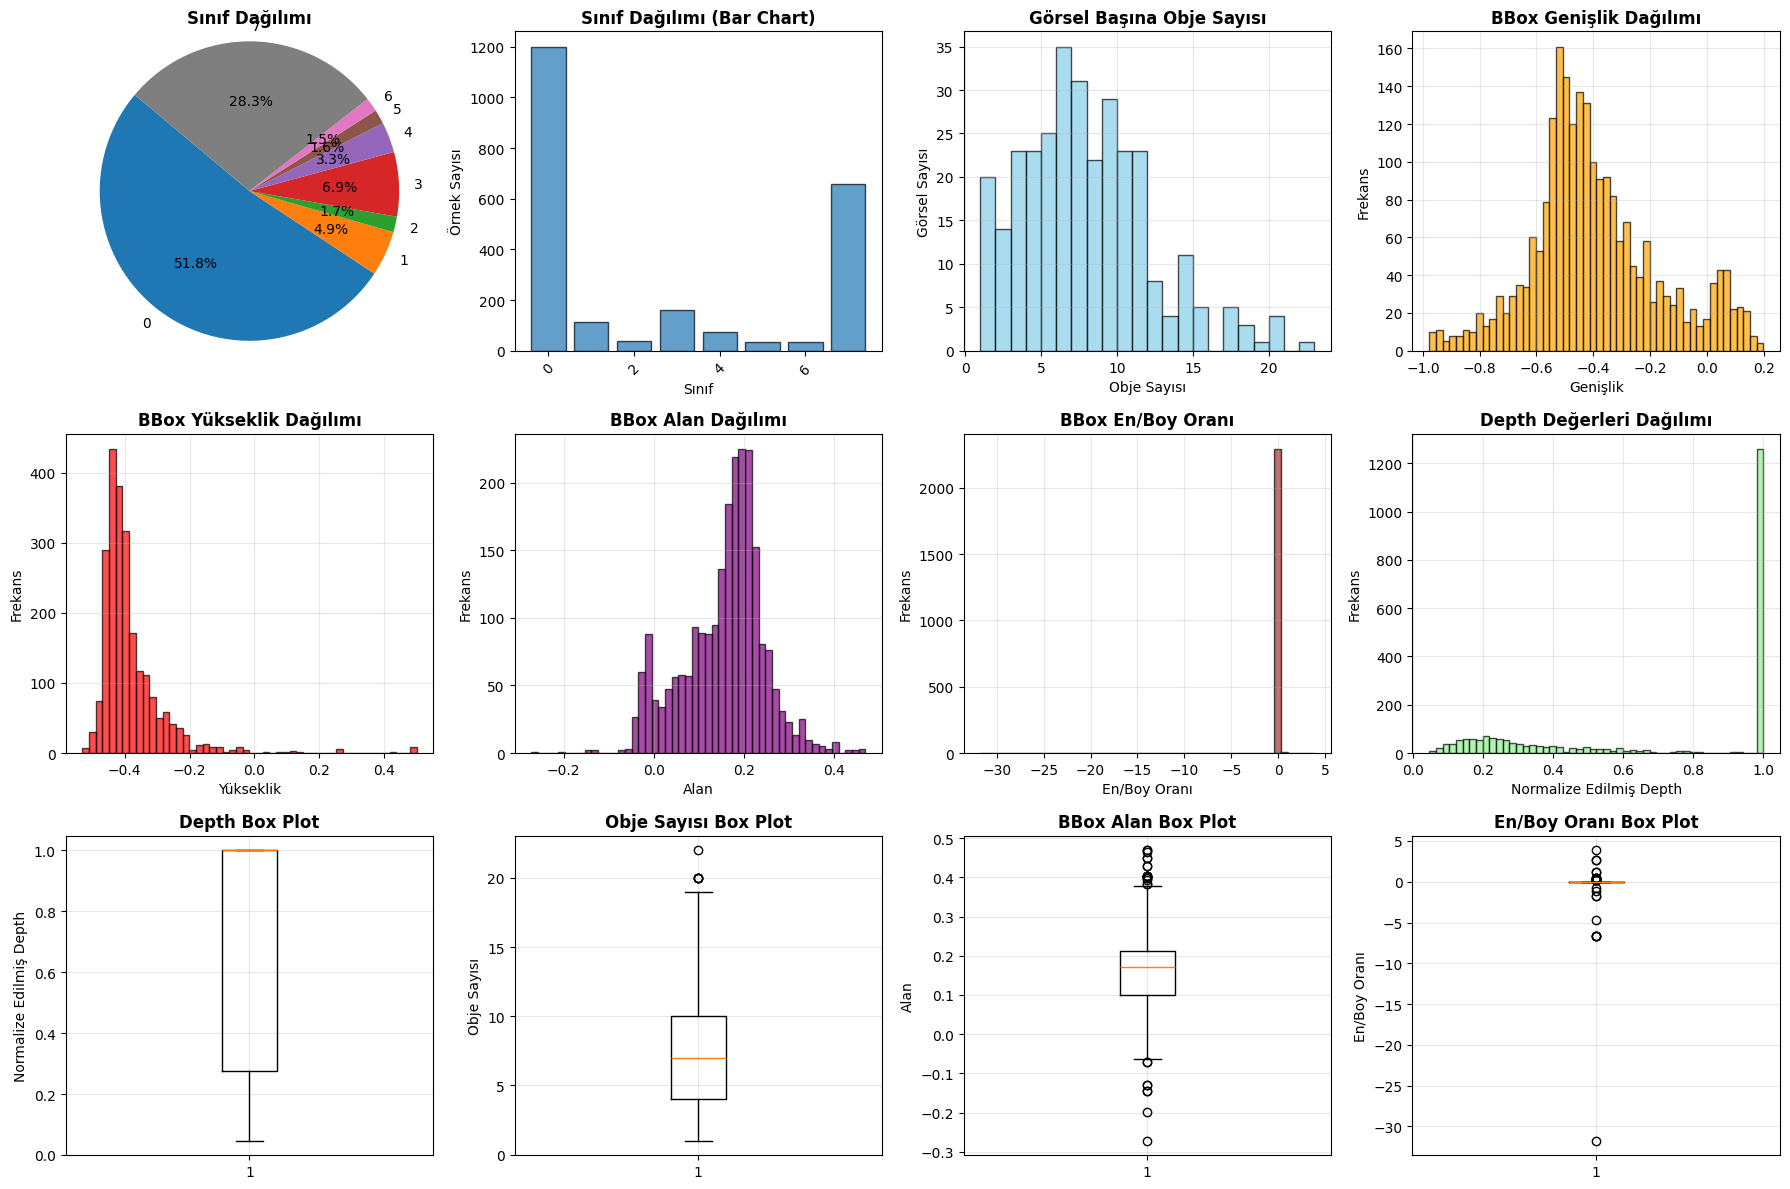

DATASET ANALİZ RAPORU

📋 GENEL BİLGİLER:
Toplam görsel sayısı:       310
Toplam obje sayısı:        2318
Toplam bbox sayısı:        2318

 SINIF DAĞILIMI:
Toplam sınıf sayısı: 8
  Sınıf 0: 1201 örnek ( 51.8%)
  Sınıf 1:  113 örnek (  4.9%)
  Sınıf 2:   39 örnek (  1.7%)
  Sınıf 3:  161 örnek (  6.9%)
  Sınıf 4:   76 örnek (  3.3%)
  Sınıf 5:   36 örnek (  1.6%)
  Sınıf 6:   35 örnek (  1.5%)
  Sınıf 7:  657 örnek ( 28.3%)

 BBOX ANALİZ RAPORU:
Ortalama genişlik:          -0.40
Ortalama yükseklik:         -0.38
Ortalama alan:               0.15
Ortalama en/boy oranı:      -0.02
Min genişlik:               -0.98
Max genişlik:                0.20
Min yükseklik:              -0.53
Max yükseklik:               0.50
Min alan:                   -0.27
Max alan:                    0.47

 OBJE SAYISI İSTATİSTİKLERİ:
Ortalama obje sayısı:   7.48
Medyan obje sayısı:     7.00
Maksimum obje sayısı:     22
Minimum obje sayısı:       1
Standart sapma:         4.22

 DEPTH ANALİZ RAPORU:
Toplam depth d

In [ ]:
results = analyze_dataset(train_dataset,device)

In [5]:
class_weights = torch.tensor([w / sum([1 / w for w in [1201,113,39,161,76,36,35,657]]) for w in [1 / w for w in [1201,113,39,161,76,36,35,657]]], dtype=torch.float32).to(device)


In [9]:
task_weights = {
            'classification': 0.3,
            'regression': 0.2,
            'detection_depth': 0.3,
            'depth_map': 0.2
        }
model = CompleteMultiTaskModel(İsPretreained=True,num_classes=8)
train_model(
  model=model,
  train_loader=train_loader,
  val_loader=val_loader,
  num_epochs=10,
  learning_rate=1e-3,
  device=device,
  save_path='best_multitask_model.pth',
  class_weights=class_weights,
  scheduler_patience=3,
  scheduler_factor=0.2,
  threshold=0.4,
  iou_threshold=0.35
)

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 162MB/s]


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 10/10 Validation : 100%|██████████| 39/39 [00:15<00:00,  2.46it/s, Acc=0.837, F1=0.801, RMSE=973.087, Prec=0.838, Rec=0.796, mAP=0.003]


epoch,▁▂▃▃▄▅▆▆▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁
train/accuracy,▁███▇█▇███
train/classification_loss,█▃▁▂▂▂▃▁▁▂
train/depth_map_loss,█▁▁▁▁▁▁▁▁▁
train/detection_depth_loss,█▁▁▁▁▁▁▁▁▁
train/f1_score,▁█████▆███
train/map,▂▅▃▅▅▇▁▆█▄
train/precision,▁███▇█▆███
train/recall,▁▇▇█▇▇▆▇█▇
train/regression_loss,█▅▃▃▂▁▁▁▂▁


In [13]:
model = CompleteMultiTaskModel(İsPretreained=True,num_classes=8)
train_model(
  model=model,
  train_loader=train_loader,
  val_loader=val_loader,
  num_epochs=10,
  learning_rate=1e-3,
  device=device,
  save_path='best_multitask_model.pth',
  class_weights=class_weights,
  scheduler_patience=3,
  scheduler_factor=0.2,
  threshold=0.4,
  iou_threshold=0.35
)

epoch,▁▃▆█
learning_rate,▁▁▁▁
train/accuracy,▁▇█▇
train/classification_loss,█▂▁▁
train/depth_map_loss,█▁▁▁
train/detection_depth_loss,█▁▁▁
train/f1_score,▁▇█▇
train/map,▁█▇█
train/precision,▁▇█▇
train/recall,▁▇█▇
train/regression_loss,█▁▂▁


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 10/10 Validation : 100%|██████████| 39/39 [00:15<00:00,  2.45it/s, Acc=0.837, F1=0.801, RMSE=0.133, Prec=0.838, Rec=0.796, mAP=0.003]


epoch,▁▂▃▃▄▅▆▆▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁
train/accuracy,▁████▇▇███
train/classification_loss,█▁▁▂▁▂▁▁▂▂
train/depth_map_loss,█▁▁▁▁▁▁▁▁▁
train/detection_depth_loss,█▁▁▁▁▁▁▁▁▁
train/f1_score,▁████▇▇███
train/map,▁█▃▆▅▆▇█▆▆
train/precision,▁████▇▇███
train/recall,▁▇███▇████
train/regression_loss,█▂▂▂▁▁▁▁▂▁


In [ ]:
def objective(trial):
    # Hiperparametre aralıkları
    task_weights = {
            'classification': 1.0,
            'regression': 1.0,
            'detection_depth': 0.2,
            'depth_map': 0.2
        }
    lr = trial.suggest_float("lr", 1e-6, 1e-3, log=True)
    threshold = trial.suggest_categorical("threshold", [0.3, 0.4, 0.5])
    iou_threshold = trial.suggest_categorical("iou_threshold", [0.05, 0.1, 0.15])
    model = CompleteMultiTaskModel(İsPretreained=True,num_classes=8).to(device)
    best_val_loss = train_model(
          model=model,
          train_loader=train_loader,
          val_loader=val_loader,
          num_epochs=5,
          learning_rate=lr,
          device=device,
          save_path='best_multitask_model.pth',
          class_weights=class_weights,
          scheduler_patience=3,
          scheduler_factor=0.2,
          threshold=threshold,
          iou_threshold=iou_threshold,
          task_weights=task_weights
        )
    return best_val_loss
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

print("En iyi parametreler:", study.best_params)

[I 2025-08-08 13:26:20,814] A new study created in memory with name: no-name-b024f656-8fcb-481e-9bcc-87d79430ac2a
wandb: Currently logged in as: mehmeteminuludag (mehmeteminuludag-kirikkale-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 2/5 Validation :  13%|█▎        | 5/39 [00:02<00:13,  2.47it/s, Acc=0.835, ClsLoss=nan, F1=0.800, RMSE=0.143, mAP=0.827, TotalLoss=nan, DepthEstimationLoss=0.001, DetectionLoss=inf, DepthMapLoss=nan]

Epoch 3/5 Validation :  13%|█▎        | 5/39 [00:02<00:13,  2.48it/s, Acc=0.835, ClsLoss=nan, F1=0.799, RMSE=0.141, mAP=0.827, TotalLoss=nan, DepthEstimationLoss=0.001, DetectionLoss=inf, DepthMapLoss=nan]

Epoch 3/5 Validation :  85%|████████▍ | 33/39 [00:13<00:02,  2.47it/s, Acc=0.835, ClsLoss=0.065, F1=0.799, RMSE=0.141, mAP=0.827, TotalLoss=0.114, DepthEstimationLoss=0.002, DetectionLoss=0.229, DepthMapLoss=0.003]